In [4]:
# General Imports
import os
import numpy as np
import pandas as pd
from time import strftime, localtime
import matplotlib.pyplot as plt
import seaborn as sn

# Deep Learning
import tensorflow as tf


from sklearn.metrics import cohen_kappa_score,f1_score,accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, \
    hamming_loss
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import check_random_state

plt.rcParams.update({'font.size': 22})
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

#TODO: fix directories
SOURCE_PATH = "/srv/workspace/research/user_based_contexts_tagging/"
SPECTROGRAMS_PATH = "/srv/workspace/research/user_based_contexts_tagging/dataset/"
OUTPUT_PATH = "/srv/workspace/research/user_based_contexts_tagging/experiments_results/"
EXTRA_OUTPUTS = "/srv/workspace/research/extra_experiment_results"

EXPERIMENTNAME = "single_label_deeper"
INPUT_SHAPE = (646, 96, 1)
EMBEDDINGS_DIM = 256
#TODO: fix labels
LABELS_LIST = ['car', 'gym', 'happy', 'night', 'relax',
       'running', 'sad', 'summer', 'work', 'workout']

global_user_embeddings = pd.read_pickle("/srv/workspace/research/user_based_contexts_tagging/GroundTruth/user_embeddings.pkl")
global_labels = pd.read_csv("/srv/workspace/research/user_based_contexts_tagging/GroundTruth/all_labels_clipped.csv")
train_partial = pd.read_csv("/srv/workspace/research/user_based_contexts_tagging/GroundTruth/train_single.csv")

BATCH_SIZE = 32

from tensorflow.keras.backend import set_session


def limit_memory_usage(gpu_memory_fraction=0.1):
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = gpu_memory_fraction
    set_session(tf.Session(config=config))


limit_memory_usage(0.3)
def dataset_from_csv(csv_path, **kwargs):
    """
        Load dataset from a csv file.
        kwargs are forwarded to the pandas.read_csv function.
    """
    df = pd.read_csv(csv_path, **kwargs)

    dataset = (
        tf.data.Dataset.from_tensor_slices(
            {
                key:df[key].values
                for key in df
            }
        )
    )
    return dataset

def set_tensor_shape(tensor, tensor_shape):
        """
            set shape for a tensor (not in place, as opposed to tf.set_shape)
        """
        tensor.set_shape(tensor_shape)
        return tensor

def check_tensor_shape(tensor_tf, target_shape):
    """
        Return a Tensorflow boolean graph that indicates whether sample[features_key] has the specified target shape
        Only check not None entries of target_shape.
    """
    res = tf.constant(True)
    for idx,target_length in enumerate(target_shape):
        if target_length:
            res = tf.logical_and(res, tf.equal(tf.constant(target_length), tf.shape(tensor_tf)[idx]))

    return res
def load_spectrogram(*args):
    """
        loads spectrogram with error tracking.
        args : song ID, path to dataset
        return:
            Features: numpy ndarray, computed features (if no error occured, otherwise: 0)
            Error: boolean, False if no error, True if an error was raised during features computation.
    """
    # TODO: edit path
    path = SPECTROGRAMS_PATH
    song_id, dummy_path = args
    try:
        # tf.logging.info(f"Load spectrogram for {song_id}")
        spect = np.load(os.path.join(path, "mels" + str(song_id) + '.npz'))['arr_0']
        if (spect.shape != (1, 646, 96)):
            # print("\n Error while computing features for" +  str(song_id) + '\n')
            return np.float32(0.0), True
            # spect = spect[:,215:215+646]
        # print(spect.shape)
        return spect, False
    except Exception as err:
        # print("\n Error while computing features for " + str(song_id) + '\n')
        return np.float32(0.0), True

def load_spectrogram_tf(sample, identifier_key="song_id",
                        path="/my_data/MelSpectograms_top20/", device="/cpu:0",
                        features_key="features"):
    """
        wrap load_spectrogram into a tensorflow function.
    """
    with tf.device(device):
        input_args = [sample[identifier_key], tf.constant(path)]
        res = tf.py_func(load_spectrogram,
                         input_args,
                         (tf.float32, tf.bool),
                         stateful=False),
        spectrogram, error = res[0]

        res = dict(list(sample.items()) + [(features_key, spectrogram), ("error", error)])
        return res


# Dataset pipelines
def get_embeddings_py(sample_user_id):
    user_embeddings = global_user_embeddings[global_user_embeddings.user_id == sample_user_id]
    samples_user_embeddings = user_embeddings.iloc[:, 1:].values.flatten()
    samples_user_embeddings = np.asarray(samples_user_embeddings[0])
    samples_user_embeddings = samples_user_embeddings.astype(np.float32)
    return samples_user_embeddings


def tf_get_embeddings_py(sample, device="/cpu:0"):
    with tf.device(device):
        input_args = [sample["user_id"]]
        user_embeddings = tf.py_func(get_embeddings_py,
                                                        input_args,
                                                        [tf.float32],
                                                        stateful=False)
        res = dict(
            list(sample.items()) + [("user_embeddings", user_embeddings)])
        return res

# Dataset pipelines
def get_labels_py(song_id,user_id):
    labels = global_labels[global_labels.song_id == song_id][global_labels.user_id == user_id]
    labels = labels.iloc[:, 2:].values.flatten() # TODO: fix this shift in dataframe columns when read
    labels = labels.astype(np.float32)
    return labels


def tf_get_labels_py(sample, device="/cpu:0"):
    with tf.device(device):
        input_args = [sample["song_id"],sample["user_id"]]
        labels = tf.py_func(get_labels_py,
                            input_args,
                            [tf.float32],
                            stateful=False)
        res = dict(list(sample.items()) + [("binary_label", labels)])
        return res


def get_dataset(input_csv, input_shape=INPUT_SHAPE, batch_size=32, shuffle=True,
                infinite_generator=True, random_crop=False, cache_dir=os.path.join(OUTPUT_PATH, "tmp/tf_cache/"),
                num_parallel_calls=32):
    # build dataset from csv file
    dataset = dataset_from_csv(input_csv)
    # Shuffle data
    if shuffle:
        dataset = dataset.shuffle(buffer_size=100, seed=1, reshuffle_each_iteration=True)

    # compute mel spectrogram
    dataset = dataset.map(lambda sample: load_spectrogram_tf(sample), num_parallel_calls=1)

    # filter out errors
    dataset = dataset.filter(lambda sample: tf.logical_not(sample["error"]))

    # map dynamic compression
    C = 100
    dataset = dataset.map(lambda sample: dict(sample, features=tf.log(1 + C * sample["features"])),
                          num_parallel_calls=num_parallel_calls)

    # Apply permute dimensions
    dataset = dataset.map(lambda sample: dict(sample, features=tf.transpose(sample["features"], perm=[1, 2, 0])),
                          num_parallel_calls=num_parallel_calls)

    # Filter by shape (remove badly shaped tensors)
    dataset = dataset.filter(lambda sample: check_tensor_shape(sample["features"], input_shape))

    # set features shape
    dataset = dataset.map(lambda sample: dict(sample,
                                              features=set_tensor_shape(sample["features"], input_shape)))

    # if cache_dir:
    #    os.makedirs(cache_dir, exist_ok=True)
    #    dataset = dataset.cache(cache_dir)

    dataset = dataset.map(lambda sample: tf_get_labels_py(sample), num_parallel_calls=1)


    # set output shape
    dataset = dataset.map(lambda sample: dict(sample, binary_label=set_tensor_shape(
        sample["binary_label"], (len(LABELS_LIST)))))

    # load embeddings
    dataset = dataset.map(lambda sample: tf_get_embeddings_py(sample), num_parallel_calls=1)
    # set weights shape
    dataset = dataset.map(lambda sample: dict(sample, user_embeddings=set_tensor_shape(
        sample["user_embeddings"], EMBEDDINGS_DIM)))

    if infinite_generator:
        # Repeat indefinitly
        dataset = dataset.repeat(count=-1)

    # Make batch
    dataset = dataset.batch(batch_size)

    # Select only features and annotation
    dataset = dataset.map(lambda sample: (
    sample["features"], sample["binary_label"], sample["user_embeddings"]))

    return dataset


def get_training_dataset(path):
    return get_dataset(path, shuffle=True,
                       cache_dir=os.path.join(OUTPUT_PATH, "tmp/tf_cache/training/"))


def get_validation_dataset(path):
    return get_dataset(path, batch_size=32, shuffle=False,
                       random_crop=False, cache_dir=os.path.join(OUTPUT_PATH, "tmp/tf_cache/validation/"))


def get_test_dataset(path):
    return get_dataset(path, batch_size=50, shuffle=False,
                       infinite_generator=False, cache_dir=os.path.join(OUTPUT_PATH, "tmp/tf_cache/test/"))


def get_weights(shape):
    w = tf.Variable(tf.truncated_normal(shape, stddev=0.1))
    # variable_summaries(w)
    return w


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    b = tf.Variable(initial)
    # variable_summaries(b)
    return b


def conv_2d(x, W, name=""):
    return tf.nn.conv2d(x, W, [1, 1, 1, 1], padding="SAME", name=name)


def max_pooling(x, shape, name=""):
    return tf.nn.max_pool(x, shape, strides=[1, 2, 2, 1], padding="SAME", name=name)


def conv_layer_with_relu(input, shape, name=""):
    W = get_weights(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv_2d(input, W, name) + b)


def full_layer(input, size):
    in_size = int(input.get_shape()[1])
    W = get_weights([in_size, size])
    b = bias_variable([size])
    return tf.matmul(input, W) + b


def get_model(x_input,user_embeddings, current_keep_prob, train_phase):
    # Define model architecture
    # C4_model
    x_norm = tf.layers.batch_normalization(x_input, training=train_phase)

    with tf.name_scope('CNN_1'):
        conv1 = conv_layer_with_relu(x_norm, [3, 3, 1, 32], name="conv_1")
        max1 = max_pooling(conv1, shape=[1, 2, 2, 1], name="max_pool_1")

    with tf.name_scope('CNN_2'):
        conv2 = conv_layer_with_relu(max1, [3, 3, 32, 64], name="conv_2")
        max2 = max_pooling(conv2, shape=[1, 2, 2, 1], name="max_pool_2")

    with tf.name_scope('CNN_3'):
        conv3 = conv_layer_with_relu(max2, [3, 3, 64, 128], name="conv_3")
        max3 = max_pooling(conv3, shape=[1, 2, 2, 1], name="max_pool_3")

    with tf.name_scope('CNN_4'):
        conv4 = conv_layer_with_relu(max3, [3, 3, 128, 256], name="conv_4")
        max4 = max_pooling(conv4, shape=[1, 2, 2, 1], name="max_pool_4")
    """
    with tf.name_scope('CNN_5'):
        conv5 = conv_layer_with_relu(max4, [3, 3, 256, 256], name="conv_5")
        max5 = max_pooling(conv5, shape=[1, 2, 2, 1], name="max_pool_5")

    with tf.name_scope('CNN_6'):
        conv6 = conv_layer_with_relu(max5, [3, 3, 256, 256], name="conv_6")
        max6 = max_pooling(conv6, shape=[1, 2, 2, 1], name="max_pool_6")

    with tf.name_scope('Fully_connected_1'):
        flattened = tf.reshape(max6, [-1, 11 * 2 * 256])
        fully1 = tf.nn.sigmoid(full_layer(flattened, 256))
    """
    with tf.name_scope('embedding_layer_1'):
        embeddings_1 = full_layer(user_embeddings, 128)
    """
    with tf.name_scope('flattened_layer_1'):
        flattened = tf.reshape(max4, [-1, 41 * 6 * 256])
        spect_1 = tf.nn.sigmoid(full_layer(flattened, 2048))
        spect_2 = tf.nn.sigmoid(full_layer(spect_1, 256))
        spect_3 = tf.nn.sigmoid(full_layer(spect_2, 128))
    """
    with tf.name_scope('Fully_connected_1'):
        flattened = tf.reshape(max4, [-1, 41 * 6 * 256])
        concatenated = tf.concat([flattened,embeddings_1],1)
        fully1 = tf.nn.sigmoid(full_layer(concatenated, 128))


    with tf.name_scope('Fully_connected_2'):
        dropped = tf.nn.dropout(fully1, keep_prob=current_keep_prob)
        logits = full_layer(dropped, len(LABELS_LIST))

    output = tf.nn.softmax(logits)
    tf.summary.histogram('outputs', output)
    return logits, output, embeddings_1,flattened

In [2]:
print("Current Experiment: " + EXPERIMENTNAME + "\n\n\n")
# Loading datasets
# TODO: fix directories

# Setting up model
y = tf.placeholder(tf.float32, [None, len(LABELS_LIST)], name="true_labels")
x_input = tf.placeholder(tf.float32, [None, 646, 96, 1], name="input")
embeddings_input = tf.placeholder(tf.float32, [None, EMBEDDINGS_DIM], name="input_embeddings")
current_keep_prob = tf.placeholder(tf.float32, name="dropout_rate")
train_phase = tf.placeholder(tf.bool, name="is_training")
logits, model_output,embed_intermediate,aud_intermediate = get_model(x_input, 
                                                                     embeddings_input, 
                                                                     current_keep_prob, train_phase)

# Setting up saving directory
experiment_name = "2020-05-05_19-46-12"
exp_dir = os.path.join(OUTPUT_PATH, EXPERIMENTNAME, experiment_name)
extra_exp_dir =  os.path.join(EXTRA_OUTPUTS, EXPERIMENTNAME, experiment_name)

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

"""
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Loading model with best validation
    saver.restore(sess, os.path.join(extra_exp_dir, "best_validation.ckpt"))
    print("Model with best validation restored before testing.")
    tvars = tf.trainable_variables()
    tvars_vals = sess.run(tvars)
    var = [val for var, val in zip(tvars, tvars_vals) if "embedding_layer_1" in (var.name)]
    #for var, val in zip(tvars, tvars_vals):
    #print(var.name, val)  # Prints the name of the variable alongside its value.
"""

Current Experiment: single_label_deeper





In [5]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Loading model with best validation
    saver.restore(sess, os.path.join(extra_exp_dir, "best_validation.ckpt"))
    test_labels = pd.read_csv(os.path.join(SOURCE_PATH, "GroundTruth/test_single.csv"))
    test_dataset = get_dataset(os.path.join(SOURCE_PATH, "GroundTruth/test_single.csv"))
    test_classes = np.zeros_like(test_labels.iloc[:, 2:].values, dtype=float)
    # test_images, test_classes = load_test_set_raw(test_split)

    TEST_NUM_STEPS = 10
    # split_size = int(len(test_classes) / TEST_NUM_STEPS)
    embeds = np.zeros([TEST_NUM_STEPS*32,128], dtype=float)
    auds = np.zeros([TEST_NUM_STEPS*32,62976], dtype=float)
    test_iterator = test_dataset.make_one_shot_iterator()
    test_next_element = test_iterator.get_next()

    for test_batch_counter in range(TEST_NUM_STEPS):
        start_idx = (test_batch_counter * BATCH_SIZE)
        end_idx = (test_batch_counter * BATCH_SIZE) + BATCH_SIZE
        test_batch = sess.run(test_next_element)
        test_batch_images = test_batch[0]
        test_batch_labels = np.squeeze(test_batch[1])
        test_embeddings = np.squeeze(test_batch[2])
        embeds[start_idx:end_idx, :],auds[start_idx:end_idx, :] = sess.run([embed_intermediate, aud_intermediate],
                                                        feed_dict={x_input: test_batch_images,
                                                                   embeddings_input: test_embeddings,
                                                                   current_keep_prob: 1.0,
                                                                   train_phase: False})

INFO:tensorflow:Restoring parameters from /srv/workspace/research/extra_experiment_results/single_label_deeper/2020-05-05_19-46-12/best_validation.ckpt


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:151: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


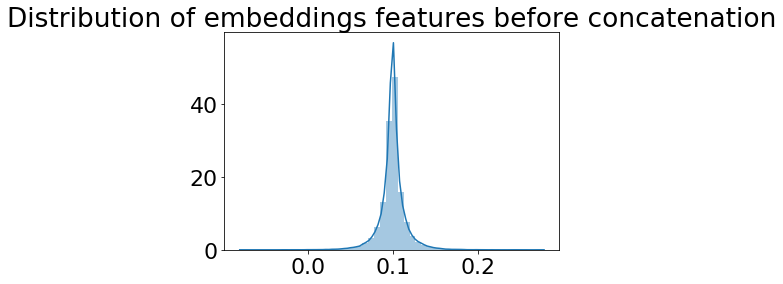

In [15]:
import seaborn as sns 
plt.title( 'Distribution of embeddings features before concatenation')
sns.distplot(embeds)

<Figure size 432x288 with 0 Axes>

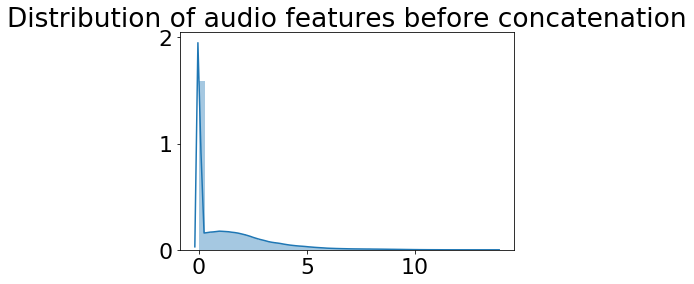

In [18]:
plt.figtext(.5, .83, 'Distribution of audio features before concatenation', ha='center')
plt.figure()
plt.title( 'Distribution of audio features before concatenation')
sns.distplot(auds)

In [22]:
import numpy as np
norms = []
for x in embeds:
    norms.append(np.linalg.norm(x))
sum(norms) / len(norms)

In [24]:
norms_aud = []
for x in auds:
    norms_aud.append(np.linalg.norm(x))
sum(norms_aud) / len(norms_aud)